# Simulation for HC gas model

In the first iteration of this model we focus only on a one-layer Hierarchy, which has one rootnet and $N_t$ subnets. We assume all of the $N_t$ subnets split the demand and fees equally amongst each other. We are looking at the behavior of the average subnet.

We make a few simplifying assumptions:
* All of the subnets and the rootnet have the same target block size, $B^T$.
* We ignore different use cases, users don't care which subnet their message goes in.
* Assume all the subnets have implemented EIP 1559.
* At any time step the number of subnets can only change by $\pm 1$

We model demand by having an overal mempool generated as a positive random variable that depends on a network demand parameter $D_t$ at time $t$.


Our goal here is to test different gas usage allocation rules for updating the parameter, $a_t$. We will try several different scenarios:

* Fixed block allocation at $a=0.5$
* Linear updating rule with maximum burn as the target
* Sigmoid updating rule with maximum burn as the target
* Additive updating rule with maximum burn as the target
* "Wild west" model, where there are no separate regular rootnet vs checkpointing gas lanes
* Sigmoid updating rule with different targets (max/min base fee, max number of subnets...)

We provide a number of demand driving functions to test the response. We try simple linear increasing demand, exponentially increasing, sinusoid oscillatory demand, it is easy to add any other demand driving curve we would wish to test.

## Setting up the details of the simulation
#### Value distribution
We assume that value assigned to a given transaction is drawn from an exponential distribution, with cumulative distribution,
$$F(v)=1-e^{\lambda v}$$

We can parametrize the value distribution for the rootnet and the subnets differently, with a lower $\lambda$ for the rootnet, meaning that users of the rootnet typically asign more value to their transactions. 


In [568]:
import numpy as np
import matplotlib.pyplot as plt

## define the value cumulative distributions, with different lambdas for rootnet and subnets

#rootnet distribution
lamr=.27

def FFr(v):
    return 1-np.exp(-lamr*v)


#subnets distribution
lams=.3
def FFs(v):
    return 1-np.exp(-lams*v)




BT=1
def bt(btm,mt,BT):
    return (1+(1/8)*(mt*(1-FF(lam,btm))-BT))*btm

#### Generating mempools randomly from demand driving curve
We now define the distributions to draw the mempool size given a certain demand. We'll use a simple Poisson distribution for now (which is not even appropriate, because Mempool gas is not an integer, but ok).

For a given target block size, $B^T$ and a given demand $D_t$, we model the demand for using the rootnet based on the current basefees for rootnet and subnet usage, as well as the parameters descibing the value distributions of rootnet vs. subnet users. we draw the mempool size for the rootnet as
$$M_{t}^r\sim {\rm Random}\left(B^T+(D_t-B^T)\frac{1}{b_r\lambda_r}\left(\frac{1}{\frac{1}{b_r\lambda_r}+\frac{1}{(g*b_c+b_N)\lambda_N}}\right)\right),$$
for $D_t>B^T$.
$$M_{t}^r\sim {\rm Poisson}(D_t)$$
for $D_t\le B^T$.

We draw the mempool for the $N$ subnets as
$$M_t^N\sim{\rm Random}\left( ( D_t-B^T)\frac{1}{(g*b_c+b_N)\lambda_N}\left(\frac{1}{\frac{1}{b_r\lambda_r}+\frac{1}{(g*b_c+b_N)\lambda_N}}\right)\right),$$
for $D_t>B^T$.
$$M_t^N=0$$
for $D_t\le B^T$.


The mempools are drawn using this demand as the parameter for some random distribution. Here we will use a Gamma distribution with mean and variance equal to this demand

In [489]:
## distribution for mempool for Rootnet

#define argument for poisson for rootnet
def poissargr(D,B,br,bc,bn,lamr,lamc,g):
    if D>B:
        return B+(D-B)*(1/(1/(br*lamr)+1/((g*bc+br)*lamc)))*1/(br*lamr)
    else:
        return D
    
#mempool or rootnet
def memer(D,B,br,bc,bn,lamr,lamc,g):
    
    memr=np.random.gamma(poissargr(D,B,br,bc,bn,lamr,lamc,g),1)
    return memr
    #return poissargr(D,B,br,bc,lamr,lamc)

#define argument for Poisson for subnets
def poissargs(D,B,br,bc,bn,lamr,lamc,g):
    if D>B:
        return (D-B)*(1/(1/(br*lamr)+1/((g*bc+br)*lamc)))*1/((g*bc+br)*lamc)
    else:
        return 0

#mempool for subnets
def memes(D,B,br,bc,bn,lamr,lamc,g):
    
    mems=np.random.gamma(poissargs(D,B,br,bc,bn,lamr,lamc,g),1)
    return mems
    #return poissargs(D,B,br,bc,lamr,lamc)



#### Generating block sizes from mempool sizes
Now we need to calculate the total block sizes, given a mempool and a value distribution, and given current base fees,
* Calculate rootnet regular usage block size,
$$B_{t}^r=M_{t}^r\left[1-F^r(b_t^r)\right].$$
* Calculate sum of blocksize of all subnets
$$B_{t}^N=M_{t}^N\left[1-F^N(b_t^N+gb_t^c)\right]$$
* Calculate checkpointing on rootnet block size
$$B_t^c=g*B_t^N$$

In [490]:
#Block size for rootnet, given a mempool and a base fee
def Br(Mr,br):
    return Mr*(1-FFr(br))

#Block size for subnets, given a mempool and a base fee
def BN(MN,bN,g,bc):
    return MN*(1-FFs(bN+g*bc))

# Checkpointing block size
def Bc(bn,g):
    return g*bn


#### Updating the basefees and allocation parameter based on the previous block sizes
Now we define the functions that will be used to update $a$ and the base fees for the EIP-1559-like formulas. 

* Update the gas allocation parameter
$$a_{t+1}=f(\Delta T_t,\Delta G_t))a_t$$
* Update new base fees:
$$ b_{t+1}^r=\left[1+\frac{1}{8}\left(B_{t}^r-a_{t+1}B^T\right)\right]b_t^r$$
$$ b_{t+1}^c=\left\{1+\frac{1}{8}\left[gB_{t}^N-(1-a_{t+1})B^T\right]\right\}b_t^c$$
$$ b_{t+1}^N=\left[1+\frac{1}{8}\left(\frac{B_{t}^N}{N_t}-B^T\right)\right]b_t^{N}$$


We have different options for the function $f(\Delta T_t,\Delta G_t))$ we want to test, for now we start with
$$f(\Delta T_t,\Delta G_t))=1-d\Delta T_t*\Delta G_t,$$
where the target is the rootnet gas burn
$$\Delta T_i=(b_t^rB_t^r+gb_t^cB_t^N)-(b_{t-1}^rB_{t-1}^r+gb_{t-1}^cB_{t-2}^N)$$
and 
$$ \Delta G_t=(gB_{t}^N-gB_{t-1}^N)-(B_{t}^{r}-B_{t-1}^{r})$$

In [491]:
# define updating functions

#define 'a' update function


## This function is defined later, with different versions, when running the algorithms
#def fa(br1,br2,Br1,Br2,bc1,bc2,BN1,BN2,g,d):
 #   targch=(br1*Br1-br2*Br2)+g*(bc1*BN1-bc2*BN2)
#    G= g*(BN1-BN2)-(Br1-Br2)
 #   return 1-d*np.tanh(targch*G)

def EIPr(Br,a,BT):
    return 1+(1/8)*(Br-a*BT)/BT

def EIPc(Bc,a,BT):
    return 1+(1/8)*(Bc-(1-a)*BT)/((1-a)*BT)

def EIPN(BN,BT,N):
    return 1+(1/8)*(BN/N-BT)/BT


## Initializing simulation

We will define some demand function, $D_t$ and initial set of parameters,
* The checkpointing rate $g$.
* The initial rootnet regular base fee, $b_0^r$.
* The initial checkpointing base fee $b_0^c$.
* The initial subnet average base fee $b_0^N$.
* The initial number of subnets $N_0$
* Initial allocation $a_0$
* The parameters for the updating function for , $d$

To start the simulation


In [571]:
#Length of the simulation
L=1000

x=np.arange(0,L)

##### THIS IS WHERE WE CHOOSE OUR DEMAND DRIVING FUNCTION#####

# LINEARLY DECREASING DEMAND
#D=np.flip(x)

#LINEARLY INCREAING DEMAND
#D=0.5*x
#D=x
#D=10*x
#D=200*x

# EXPONENTIALLY INCREASING DEMAND
#D=np.exp(.005*x+1)
D=np.exp(.02*x+1)

#SINUSOIDAL DEMAND
#D=500*(np.sin(.005*x))**2
#D=5000*(np.sin(.005*x))**2
#D=500*(np.sin(.05*x))**2
#D=5000*(np.sin(.05*x))**2


#Checkpointing rate
g=.01

#initial base fees
br0=1
bc0=1
bN0=1

#initial allocation
a0=.5
a1=0.5

#initial number of subnets
N0=3.

# parameter for updating function
d=1/16

#target blocksize
BT=10.




## Let's run a simulation!

## 50-50 model

In this first simulation we keep the allocation constant at $a=0.5$



In [572]:
#define output vectors

brL=np.zeros(L)
bcL=np.zeros(L)
bNL=np.zeros(L)
NL=np.zeros(L)
a=np.zeros(L)

brL[0]=br0
bcL[0]=bc0
bNL[0]=bN0
NL[0]=N0
a[0]=a0
a[1]=a1

Mr=np.zeros(L)
Ms=np.zeros(L)

In [573]:
#run stuff!

#generate mempools


#first two steps without updating $a$
for l in range(0,1):
    Mr[l]=memer(D[l],BT,brL[l],bcL[l],bNL[l],lamr,lams,g)
    Ms[l]=memes(D[l],BT,brL[l],bcL[l],bNL[l],lamr,lams,g)
    BBr=Br(Mr[l],brL[l])
    BBN=BN(Ms[l],bNL[l],g,bcL[l])
    BBc=Bc(BBN,g)
    
    #update base fees
    brL[l+1]=EIPr(BBr,a[l],BT)*brL[l]
    bcL[l+1]=EIPc(BBc,a[l],BT)*bcL[l]
    bNL[l+1]=EIPN(BBN,BT,NL[l])*bNL[l]
    
    ### Allocation rule
    a[l+1]=0.5
    
    ###
    if NL[l]==0:
        NL[l+1]=1
        
    elif NL[l]==1:
        b1=EIPN(BBN,BT,1)*bNL[l]
        b2=EIPN(BBN,BT,2)*bNL[l]
        B1=BN(Ms[l],b1,g,bcL[l])
        B2=BN(Ms[l],b2,g,bcL[l])
        NL[l+1]=1+np.argmax([b1*B1,b2*B2])
        
    elif NL[l]>1:
        b1=EIPN(BBN,BT,NL[l]-1)*bNL[l]
        b2=EIPN(BBN,BT,NL[l])*bNL[l]
        b3=EIPN(BBN,BT,NL[l]+1)*bNL[l]
        B1=BN(Ms[l],b1,g,bcL[l])
        B2=BN(Ms[l],b2,g,bcL[l])
        B3=BN(Ms[l],b3,g,bcL[l])
        NL[l+1]=NL[l]-1+np.argmax([b1*B1,b2*B2,b3*B3])
    
    
    
    
    
##The rest of the steps
for l in range(1,L-1):
    Mr[l]=memer(D[l],BT,brL[l],bcL[l],bNL[l],lamr,lams,g)
    Ms[l]=memes(D[l],BT,brL[l],bcL[l],bNL[l],lamr,lams,g)
    BBr=Br(Mr[l],brL[l])
    BBN=BN(Ms[l],bNL[l],g,bcL[l])
    BBc=Bc(BBN,g)
    
    #update base fees
    brL[l+1]=EIPr(BBr,a[l],BT)*brL[l]
    bcL[l+1]=EIPc(BBc,a[l],BT)*bcL[l]
    bNL[l+1]=EIPN(BBN,BT,NL[l])*bNL[l]
    
    ### first go with constant 50-50 split (here would go fancy HC algorithm)
    a[l+1]=0.5
    
    ###
    if NL[l]==0:
        NL[l+1]=1
        
    elif NL[l]==1:
        b1=EIPN(BBN,BT,1)*bNL[l]
        b2=EIPN(BBN,BT,2)*bNL[l]
        B1=BN(Ms[l],b1,g,bcL[l])
        B2=BN(Ms[l],b2,g,bcL[l])
        NL[l+1]=1+np.argmax([b1*B1,b2*B2])
        
    elif NL[l]>1:
        b1=EIPN(BBN,BT,NL[l]-1)*bNL[l]
        b2=EIPN(BBN,BT,NL[l])*bNL[l]
        b3=EIPN(BBN,BT,NL[l]+1)*bNL[l]
        B1=BN(Ms[l],b1,g,bcL[l])
        B2=BN(Ms[l],b2,g,bcL[l])
        B3=BN(Ms[l],b3,g,bcL[l])
        NL[l+1]=NL[l]-1+np.argmax([b1*B1,b2*B2,b3*B3])
    

We now produce some relevant plots:
* The optimal number of subnets over time
* The allocation parameter, $a$ over time 
* The regular rootnet base fee over time
* The total base fee for subnet usage over time(subnet base fee+ g*checkpointing base fee)
* The Total rootnet revenue (rootnet base fee* rootnet gas usage+ checkpointing base fee* checkpointing gas usage)

Total rootnet token burn is 5413380.030049399


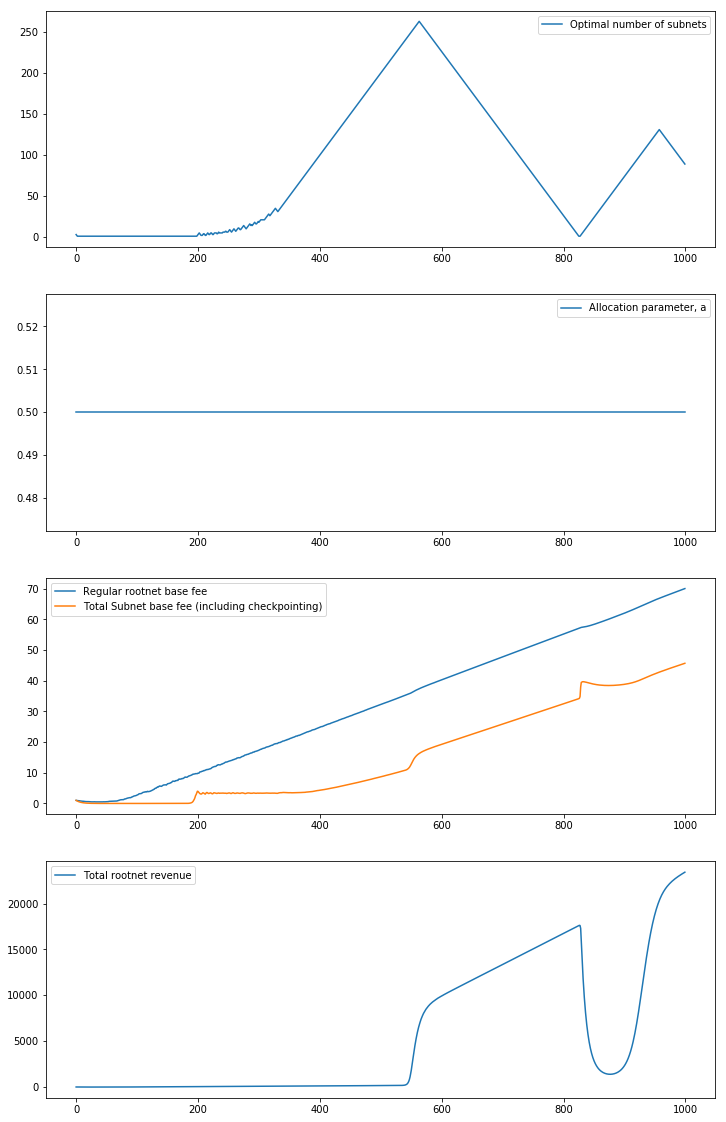

In [588]:
fig, axs = plt.subplots( 4,1,figsize=(12, 20))

axs[0].plot(x,NL,label='Optimal number of subnets')
axs[0].legend()

axs[1].plot(x,a,label="Allocation parameter, a")
axs[1].legend()

axs[2].plot(x,brL,label="Regular rootnet base fee")
axs[2].plot(x,g*bcL+bNL,label="Total Subnet base fee (including checkpointing)")
axs[2].legend()

axs[3].plot(x,brL*BBr+g*bcL*BBN,label="Total rootnet revenue")
axs[3].legend()


#Print total network revenue for whole period
print("Total rootnet token burn is", np.sum(brL*BBr+g*bcL*BBN))

## Linear updating rule for $a$

In [589]:

def fa(br1,br2,Br1,Br2,bc1,bc2,BN1,BN2,g,d):
    
    targch=(br1*Br1-br2*Br2)+g*(bc1*BN1-bc2*BN2)
    G= g*(BN1-BN2)-(Br1-Br2)
    return 1-d*(targch*G/BT)


In [591]:
#define output vectors

brL=np.zeros(L)
bcL=np.zeros(L)
bNL=np.zeros(L)
NL=np.zeros(L)
a=np.zeros(L)


BBr=np.zeros(L)
BBN=np.zeros(L)
BBc=np.zeros(L)
    
brL[0]=br0
bcL[0]=bc0
bNL[0]=bN0
NL[0]=N0
a[0]=a0
a[1]=a1

Mr=np.zeros(L)
Ms=np.zeros(L)

In [592]:
#run stuff!

#generate mempools

ffa=np.zeros(L)

#first two steps without updating $a$
for l in range (0,1):
    Mr[l]=memer(D[l],BT,brL[l],bcL[l],bNL[l],lamr,lams,g)
    Ms[l]=memes(D[l],BT,brL[l],bcL[l],bNL[l],lamr,lams,g)
    BBr[l]=Br(Mr[l],brL[l])
    BBN[l]=BN(Ms[l],bNL[l],g,bcL[l])
    BBc[l]=Bc(BBN[l],g)
    
    #update base fees
    brL[l+1]=EIPr(BBr[l],a[l],BT)*brL[l]
    bcL[l+1]=EIPc(BBc[l],a[l],BT)*bcL[l]
    bNL[l+1]=EIPN(BBN[l],BT,NL[l])*bNL[l]
    
    ### first go with constant 50-50 split (here would go fancy HC algorithm)
    a[l+1]=0.5

    
    ###
    if NL[l]==0:
        NL[l+1]=1
        
    elif NL[l]==1:
        b1=EIPN(BBN[l],BT,1)*bNL[l]
        b2=EIPN(BBN[l],BT,2)*bNL[l]
        B1=BN(Ms[l],b1,g,bcL[l])
        B2=BN(Ms[l],b2,g,bcL[l])
        NL[l+1]=1+np.argmax([b1*B1,b2*B2])
        
    elif NL[l]>1:
        b1=EIPN(BBN[l],BT,NL[l]-1)*bNL[l]
        b2=EIPN(BBN[l],BT,NL[l])*bNL[l]
        b3=EIPN(BBN[l],BT,NL[l]+1)*bNL[l]
        B1=BN(Ms[l],b1,g,bcL[l])
        B2=BN(Ms[l],b2,g,bcL[l])
        B3=BN(Ms[l],b3,g,bcL[l])
        NL[l+1]=int(NL[l]-1+np.argmax([b1*B1,b2*B2,b3*B3]))
    
    
    
    
    
##The rest of the steps
for l in range(1,L-1):
    Mr[l]=memer(D[l],BT,brL[l-1],bcL[l-1],bNL[l-1],lamr,lams,g)
    Ms[l]=memes(D[l],BT,brL[l-1],bcL[l-1],bNL[l-1],lamr,lams,g)
    BBr[l]=Br(Mr[l],brL[l])
    BBN[l]=BN(Ms[l],bNL[l],g,bcL[l])
    BBc[l]=Bc(BBN[l],g)
    
    #update base fees
    brL[l+1]=EIPr(BBr[l],a[l],BT)*brL[l]
    bcL[l+1]=EIPc(BBc[l],a[l],BT)*bcL[l]
    bNL[l+1]=EIPN(BBN[l],BT,NL[l])*bNL[l]
    
    
    ### first go with constant 50-50 split (here would go fancy HC algorithm)
    ffa[l]=fa(brL[l],brL[l-1],BBr[l],BBr[l-1],bcL[l],bcL[l-1],BBN[l],BBN[l-1],g,d)
    a[l+1]=fa(brL[l],brL[l-1],BBr[l],BBr[l-1],bcL[l],bcL[l-1],BBN[l],BBN[l-1],g,d)*a[l]
    if a[l+1]>1:
        a[l+1]=a[l]
    elif a[l+1]<0:
        a[l+1]=a[1]
   
  
    ###
    if NL[l]==0:
        NL[l+1]=1
        
    elif NL[l]==1:
        b1=EIPN(BBN[l],BT,1)*bNL[l]
        b2=EIPN(BBN[l],BT,2)*bNL[l]
        bc=EIPc(BBc[l],a[l],BT)*bcL[l]
        B1=BN(Ms[l],b1,g,bcL[l])
        B2=BN(Ms[l],b2,g,bcL[l])
        NL[l+1]=1+np.argmax([b1*B1-bc*g*B1,b2*B2-bc*g*B2])
        
    elif NL[l]>1:
        b1=EIPN(BBN[l],BT,NL[l]-1)*bNL[l]
        b2=EIPN(BBN[l],BT,NL[l])*bNL[l]
        b3=EIPN(BBN[l],BT,NL[l]+1)*bNL[l]
        bc=EIPc(BBc[l],a[l],BT)*bcL[l]
        B1=BN(Ms[l],b1,g,bcL[l])
        B2=BN(Ms[l],b2,g,bcL[l])
        B3=BN(Ms[l],b3,g,bcL[l])
        NL[l+1]=int(NL[l]-1+np.argmax([b1*B1-bc*g*B1,b2*B2-bc*g*B2,b3*B3-bc*g*B3]))
    
  

Total rootnet token burn is 5206330.656107999


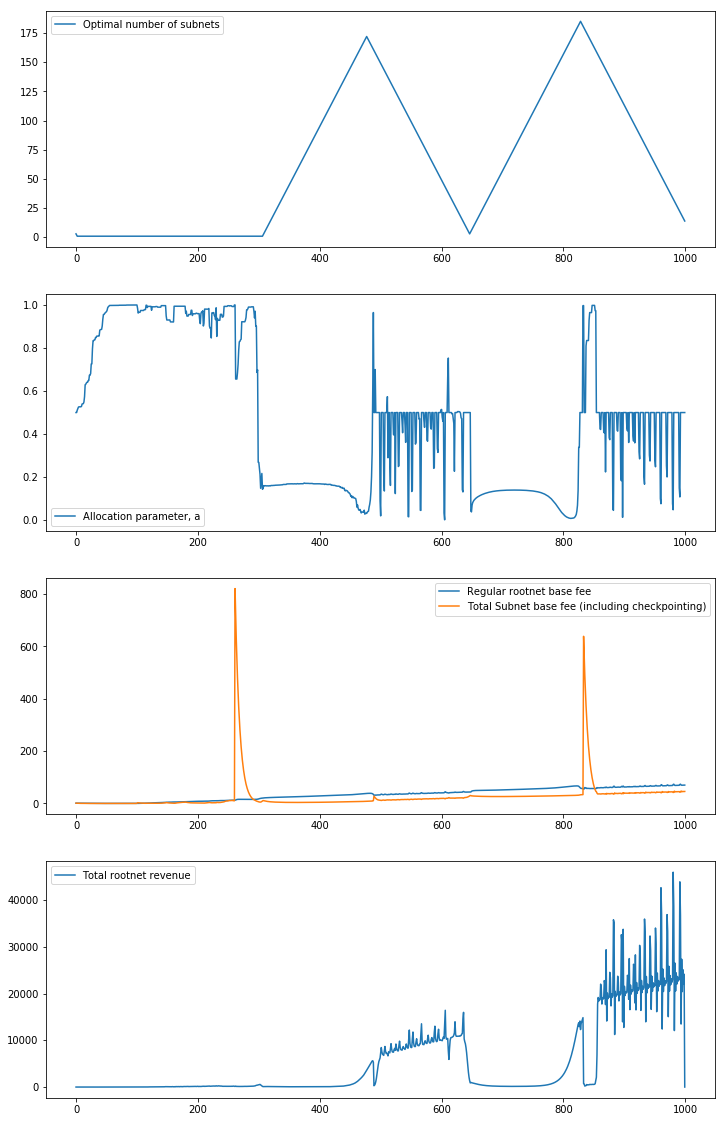

In [593]:
fig, axs = plt.subplots( 4,1,figsize=(12, 20))

axs[0].plot(x,NL,label='Optimal number of subnets')
axs[0].legend()

axs[1].plot(x,a,label="Allocation parameter, a")
axs[1].legend()

axs[2].plot(x,brL,label="Regular rootnet base fee")
axs[2].plot(x,g*bcL+bNL,label="Total Subnet base fee (including checkpointing)")
axs[2].legend()

axs[3].plot(x,brL*BBr+g*bcL*BBN,label="Total rootnet revenue")
axs[3].legend()


#Print total network revenue for whole period
print("Total rootnet token burn is", np.sum(brL*BBr+g*bcL*BBN))

## Tanh updating rule

In [594]:
def fa(br1,br2,Br1,Br2,bc1,bc2,BN1,BN2,g,d):
    
    targch=(br1*Br1-br2*Br2)+g*(bc1*BN1-bc2*BN2)
    G= g*(BN1-BN2)-(Br1-Br2)
    return 1-d*np.tanh(targch*G/BT)


In [595]:
#define output vectors

brL=np.zeros(L)
bcL=np.zeros(L)
bNL=np.zeros(L)
NL=np.zeros(L)
a=np.zeros(L)


BBr=np.zeros(L)
BBN=np.zeros(L)
BBc=np.zeros(L)
    
brL[0]=br0
bcL[0]=bc0
bNL[0]=bN0
NL[0]=N0
a[0]=a0
a[1]=a1

Mr=np.zeros(L)
Ms=np.zeros(L)

In [596]:
#run stuff!

#generate mempools

ffa=np.zeros(L)

#first two steps without updating $a$
for l in range (0,1):
    Mr[l]=memer(D[l],BT,brL[l],bcL[l],bNL[l],lamr,lams,g)
    Ms[l]=memes(D[l],BT,brL[l],bcL[l],bNL[l],lamr,lams,g)
    BBr[l]=Br(Mr[l],brL[l])
    BBN[l]=BN(Ms[l],bNL[l],g,bcL[l])
    BBc[l]=Bc(BBN[l],g)
    
    #update base fees
    brL[l+1]=EIPr(BBr[l],a[l],BT)*brL[l]
    bcL[l+1]=EIPc(BBc[l],a[l],BT)*bcL[l]
    bNL[l+1]=EIPN(BBN[l],BT,NL[l])*bNL[l]
    
    ### first go with constant 50-50 split (here would go fancy HC algorithm)
    a[l+1]=0.5

    
    ###
    if NL[l]==0:
        NL[l+1]=1
        
    elif NL[l]==1:
        b1=EIPN(BBN[l],BT,1)*bNL[l]
        b2=EIPN(BBN[l],BT,2)*bNL[l]
        B1=BN(Ms[l],b1,g,bcL[l])
        B2=BN(Ms[l],b2,g,bcL[l])
        NL[l+1]=1+np.argmax([b1*B1,b2*B2])
        
    elif NL[l]>1:
        b1=EIPN(BBN[l],BT,NL[l]-1)*bNL[l]
        b2=EIPN(BBN[l],BT,NL[l])*bNL[l]
        b3=EIPN(BBN[l],BT,NL[l]+1)*bNL[l]
        B1=BN(Ms[l],b1,g,bcL[l])
        B2=BN(Ms[l],b2,g,bcL[l])
        B3=BN(Ms[l],b3,g,bcL[l])
        NL[l+1]=int(NL[l]-1+np.argmax([b1*B1,b2*B2,b3*B3]))
    
    
    
    
    
##The rest of the steps
for l in range(1,L-1):
    Mr[l]=memer(D[l],BT,brL[l-1],bcL[l-1],bNL[l-1],lamr,lams,g)
    Ms[l]=memes(D[l],BT,brL[l-1],bcL[l-1],bNL[l-1],lamr,lams,g)
    BBr[l]=Br(Mr[l],brL[l])
    BBN[l]=BN(Ms[l],bNL[l],g,bcL[l])
    BBc[l]=Bc(BBN[l],g)
    
    #update base fees
    brL[l+1]=EIPr(BBr[l],a[l],BT)*brL[l]
    bcL[l+1]=EIPc(BBc[l],a[l],BT)*bcL[l]
    bNL[l+1]=EIPN(BBN[l],BT,NL[l])*bNL[l]
    
    
    ### first go with constant 50-50 split (here would go fancy HC algorithm)
    ffa[l]=fa(brL[l],brL[l-1],BBr[l],BBr[l-1],bcL[l],bcL[l-1],BBN[l],BBN[l-1],g,d)
    a[l+1]=fa(brL[l],brL[l-1],BBr[l],BBr[l-1],bcL[l],bcL[l-1],BBN[l],BBN[l-1],g,d)*a[l]
    if a[l+1]>1:
        a[l+1]=a[l]
    elif a[l+1]<0:
        a[l+1]=a[1]
   
  
    ###
    if NL[l]==0:
        NL[l+1]=1
        
    elif NL[l]==1:
        b1=EIPN(BBN[l],BT,1)*bNL[l]
        b2=EIPN(BBN[l],BT,2)*bNL[l]
        bc=EIPc(BBc[l],a[l],BT)*bcL[l]
        B1=BN(Ms[l],b1,g,bcL[l])
        B2=BN(Ms[l],b2,g,bcL[l])
        NL[l+1]=1+np.argmax([b1*B1-bc*g*B1,b2*B2-bc*g*B2])
        
    elif NL[l]>1:
        b1=EIPN(BBN[l],BT,NL[l]-1)*bNL[l]
        b2=EIPN(BBN[l],BT,NL[l])*bNL[l]
        b3=EIPN(BBN[l],BT,NL[l]+1)*bNL[l]
        bc=EIPc(BBc[l],a[l],BT)*bcL[l]
        B1=BN(Ms[l],b1,g,bcL[l])
        B2=BN(Ms[l],b2,g,bcL[l])
        B3=BN(Ms[l],b3,g,bcL[l])
        NL[l+1]=int(NL[l]-1+np.argmax([b1*B1-bc*g*B1,b2*B2-bc*g*B2,b3*B3-bc*g*B3]))
    
  

Total rootnet token burn is 6342121.180195769


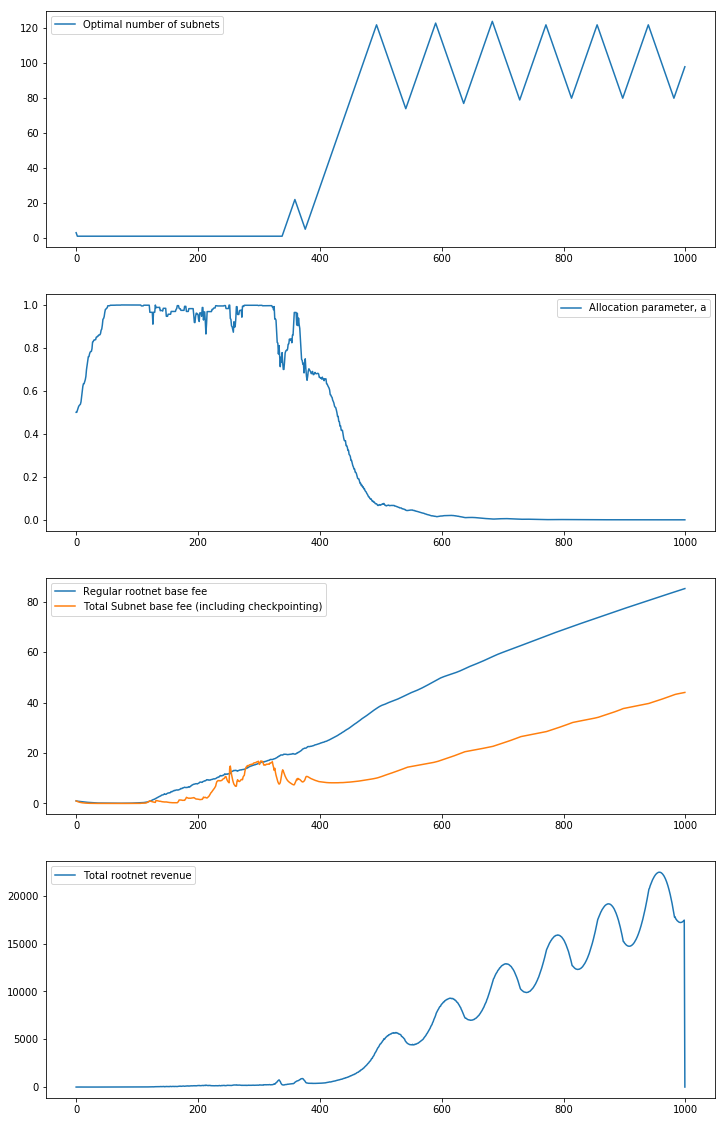

In [597]:
fig, axs = plt.subplots( 4,1,figsize=(12, 20))

axs[0].plot(x,NL,label='Optimal number of subnets')
axs[0].legend()

axs[1].plot(x,a,label="Allocation parameter, a")
axs[1].legend()

axs[2].plot(x,brL,label="Regular rootnet base fee")
axs[2].plot(x,g*bcL+bNL,label="Total Subnet base fee (including checkpointing)")
axs[2].legend()

axs[3].plot(x,brL*BBr+g*bcL*BBN,label="Total rootnet revenue")
axs[3].legend()


#Print total network revenue for whole period
print("Total rootnet token burn is", np.sum(brL*BBr+g*bcL*BBN))

## Additive rule for updating a


In [598]:
def fa(br1,br2,Br1,Br2,bc1,bc2,BN1,BN2,g,d):
    targch=(br1-br2)*Br1+g*(bc1-bc2)*BN1
    G= g*(BN1-BN2)-(Br1-Br2)
    return 1-d*np.sign(targch*G)*(targch**2+G**2)

In [599]:
#define output vectors

brL=np.zeros(L)
bcL=np.zeros(L)
bNL=np.zeros(L)
NL=np.zeros(L)
a=np.zeros(L)


BBr=np.zeros(L)
BBN=np.zeros(L)
BBc=np.zeros(L)
    
brL[0]=br0
bcL[0]=bc0
bNL[0]=bN0
NL[0]=N0
a[0]=a0
a[1]=a1

In [600]:
#run stuff!

#generate mempools

ffa=np.zeros(L)

#first two steps without updating $a$
for l in range (0,1):
    Mr[l]=memer(D[l],BT,brL[l],bcL[l],bNL[l],lamr,lams,g)
    Ms[l]=memes(D[l],BT,brL[l],bcL[l],bNL[l],lamr,lams,g)
    BBr[l]=Br(Mr[l],brL[l])
    BBN[l]=BN(Ms[l],bNL[l],g,bcL[l])
    BBc[l]=Bc(BBN[l],g)
    
    #update base fees
    brL[l+1]=EIPr(BBr[l],a[l],BT)*brL[l]
    bcL[l+1]=EIPc(BBc[l],a[l],BT)*bcL[l]
    bNL[l+1]=EIPN(BBN[l],BT,NL[l])*bNL[l]
    
    ### first go with constant 50-50 split (here would go fancy HC algorithm)
    a[l+1]=0.5

    
    ###
    if NL[l]==0:
        NL[l+1]=1
        
    elif NL[l]==1:
        b1=EIPN(BBN[l],BT,1)*bNL[l]
        b2=EIPN(BBN[l],BT,2)*bNL[l]
        B1=BN(Ms[l],b1,g,bcL[l])
        B2=BN(Ms[l],b2,g,bcL[l])
        NL[l+1]=1+np.argmax([b1*B1,b2*B2])
        
    elif NL[l]>1:
        b1=EIPN(BBN[l],BT,NL[l]-1)*bNL[l]
        b2=EIPN(BBN[l],BT,NL[l])*bNL[l]
        b3=EIPN(BBN[l],BT,NL[l]+1)*bNL[l]
        B1=BN(Ms[l],b1,g,bcL[l])
        B2=BN(Ms[l],b2,g,bcL[l])
        B3=BN(Ms[l],b3,g,bcL[l])
        NL[l+1]=int(NL[l]-1+np.argmax([b1*B1,b2*B2,b3*B3]))
    
    
    
    
    
##The rest of the steps
for l in range(1,L-1):
    Mr[l]=memer(D[l],BT,brL[l-1],bcL[l-1],bNL[l-1],lamr,lams,g)
    Ms[l]=memes(D[l],BT,brL[l-1],bcL[l-1],bNL[l-1],lamr,lams,g)
    BBr[l]=Br(Mr[l],brL[l])
    BBN[l]=BN(Ms[l],bNL[l],g,bcL[l])
    BBc[l]=Bc(BBN[l],g)
    
    #update base fees
    brL[l+1]=EIPr(BBr[l],a[l],BT)*brL[l]
    bcL[l+1]=EIPc(BBc[l],a[l],BT)*bcL[l]
    bNL[l+1]=EIPN(BBN[l],BT,NL[l])*bNL[l]
    
    
    ### first go with constant 50-50 split (here would go fancy HC algorithm)
    ffa[l]=fa(brL[l],brL[l-1],BBr[l],BBr[l-1],bcL[l],bcL[l-1],BBN[l],BBN[l-1],g,d)
    a[l+1]=fa(brL[l],brL[l-1],BBr[l],BBr[l-1],bcL[l],bcL[l-1],BBN[l],BBN[l-1],g,d)*a[l]
    if a[l+1]>1:
        a[l+1]=a[l]
    elif a[l+1]<0:
        a[l+1]=a[1]
   
  
    ###
    if NL[l]==0:
        NL[l+1]=1
        
    elif NL[l]==1:
        b1=EIPN(BBN[l],BT,1)*bNL[l]
        b2=EIPN(BBN[l],BT,2)*bNL[l]
        bc=EIPc(BBc[l],a[l],BT)*bcL[l]
        B1=BN(Ms[l],b1,g,bcL[l])
        B2=BN(Ms[l],b2,g,bcL[l])
        NL[l+1]=1+np.argmax([b1*B1-bc*g*B1,b2*B2-bc*g*B2])
        
    elif NL[l]>1:
        b1=EIPN(BBN[l],BT,NL[l]-1)*bNL[l]
        b2=EIPN(BBN[l],BT,NL[l])*bNL[l]
        b3=EIPN(BBN[l],BT,NL[l]+1)*bNL[l]
        bc=EIPc(BBc[l],a[l],BT)*bcL[l]
        B1=BN(Ms[l],b1,g,bcL[l])
        B2=BN(Ms[l],b2,g,bcL[l])
        B3=BN(Ms[l],b3,g,bcL[l])
        NL[l+1]=int(NL[l]-1+np.argmax([b1*B1-bc*g*B1,b2*B2-bc*g*B2,b3*B3-bc*g*B3]))
    
  

Total rootnet token burn is 5787483.407792401


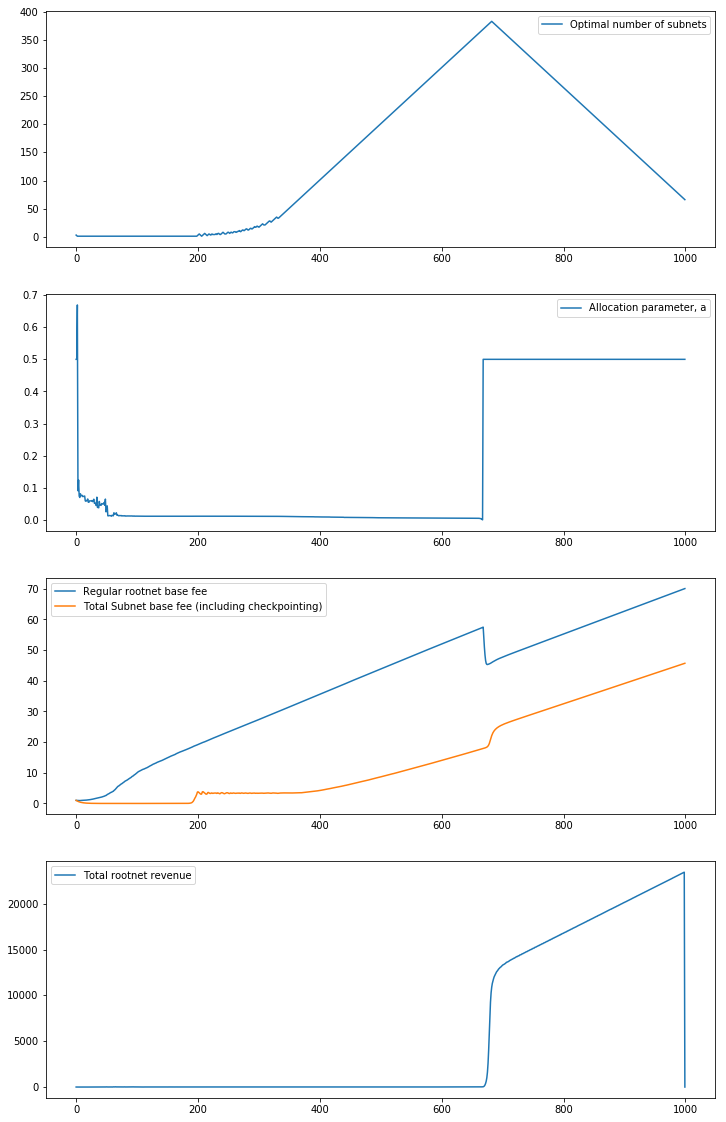

In [601]:
fig, axs = plt.subplots( 4,1,figsize=(12, 20))

axs[0].plot(x,NL,label='Optimal number of subnets')
axs[0].legend()

axs[1].plot(x,a,label="Allocation parameter, a")
axs[1].legend()

axs[2].plot(x,brL,label="Regular rootnet base fee")
axs[2].plot(x,g*bcL+bNL,label="Total Subnet base fee (including checkpointing)")
axs[2].legend()

axs[3].plot(x,brL*BBr+g*bcL*BBN,label="Total rootnet revenue")
axs[3].legend()


#Print total network revenue for whole period
print("Total rootnet token burn is", np.sum(brL*BBr+g*bcL*BBN))

## Wild West

In this model, there is no separate checkpointing base fee, as this is the same as the regular rootnet base fee. The block belongs to whoever can pay the base fee, whether it is for checkpointing or regular usage.

In [605]:
#define output vectors

brL=np.zeros(L)
bcL=np.zeros(L)
bNL=np.zeros(L)
NL=np.zeros(L)
a=np.zeros(L)

brL[0]=br0
bcL[0]=bc0
bNL[0]=bN0
NL[0]=N0
a[0]=a0
a[1]=a1

Mr=np.zeros(L)
Ms=np.zeros(L)

In [606]:
#run stuff!

#generate mempools

ffa=np.zeros(L)

#first two steps without updating $a$
for l in range (0,1):
    Mr[l]=memer(D[l],BT,brL[l],bcL[l],bNL[l],lamr,lams,g)
    Ms[l]=memes(D[l],BT,brL[l],bcL[l],bNL[l],lamr,lams,g)
    BBr[l]=Br(Mr[l],brL[l])
    BBN[l]=BN(Ms[l],bNL[l],g,brL[l])
    BBc[l]=Bc(BBN[l],g)
    
    #update base fees
    brL[l+1]=EIPr(BBr[l],1,BT)*brL[l]
    #bcL[l+1]=EIPc(BBc[l],a[l],BT)*bcL[l]
    bNL[l+1]=EIPN(BBN[l],BT,NL[l])*bNL[l]
    
    ### first go with constant 50-50 split (here would go fancy HC algorithm)
   # a[l+1]=0.5

    
    ###
    if NL[l]==0:
        NL[l+1]=1
        
    elif NL[l]==1:
        b1=EIPN(BBN[l],BT,1)*bNL[l]
        b2=EIPN(BBN[l],BT,2)*bNL[l]
        B1=BN(Ms[l],b1,g,brL[l])
        B2=BN(Ms[l],b2,g,brL[l])
        NL[l+1]=1+np.argmax([b1*B1,b2*B2])
        
    elif NL[l]>1:
        b1=EIPN(BBN[l],BT,NL[l]-1)*bNL[l]
        b2=EIPN(BBN[l],BT,NL[l])*bNL[l]
        b3=EIPN(BBN[l],BT,NL[l]+1)*bNL[l]
        B1=BN(Ms[l],b1,g,bcL[l])
        B2=BN(Ms[l],b2,g,bcL[l])
        B3=BN(Ms[l],b3,g,bcL[l])
        NL[l+1]=int(NL[l]-1+np.argmax([b1*B1,b2*B2,b3*B3]))
    
    
    
    
    
##The rest of the steps
for l in range(1,L-1):
    Mr[l]=memer(D[l],BT,brL[l-1],brL[l-1],bNL[l-1],lamr,lams,g)
    Ms[l]=memes(D[l],BT,brL[l-1],brL[l-1],bNL[l-1],lamr,lams,g)
    BBr[l]=Br(Mr[l],brL[l])
    BBN[l]=BN(Ms[l],bNL[l],g,brL[l])
    BBc[l]=Bc(BBN[l],g)
    
    #update base fees
    brL[l+1]=EIPr(BBr[l],1,BT)*brL[l]
    #bcL[l+1]=EIPc(BBc[l],a[l],BT)*bcL[l]
    bNL[l+1]=EIPN(BBN[l],BT,NL[l])*bNL[l]
    
    
    ### first go with constant 50-50 split (here would go fancy HC algorithm)
    #ffa[l]=fa(brL[l],brL[l-1],BBr[l],BBr[l-1],bcL[l],bL[l-1],BBN[l],BBN[l-1],g,d)
    #a[l+1]=fa(brL[l],brL[l-1],BBr[l],BBr[l-1],bcL[l],bcL[l-1],BBN[l],BBN[l-1],g,d)*a[l]
    #if a[l+1]>1:
     #   a[l+1]=a[l]
    #elif a[l+1]<0:
     #   a[l+1]=a[1]
   
  
    ###
    if NL[l]==0:
        NL[l+1]=1
        
    elif NL[l]==1:
        b1=EIPN(BBN[l],BT,1)*bNL[l]
        b2=EIPN(BBN[l],BT,2)*bNL[l]
        bc=EIPr(BBc[l]+BBr[l],1,BT)*brL[l]
        B1=BN(Ms[l],b1,g,brL[l])
        B2=BN(Ms[l],b2,g,brL[l])
        NL[l+1]=1+np.argmax([b1*B1-bc*g*B1,b2*B2-bc*g*B2])
        
    elif NL[l]>1:
        b1=EIPN(BBN[l],BT,NL[l]-1)*bNL[l]
        b2=EIPN(BBN[l],BT,NL[l])*bNL[l]
        b3=EIPN(BBN[l],BT,NL[l]+1)*bNL[l]
        bc=EIPr(BBc[l]+BBr[l],1,BT)*brL[l]
        B1=BN(Ms[l],b1,g,brL[l])
        B2=BN(Ms[l],b2,g,brL[l])
        B3=BN(Ms[l],b3,g,brL[l])
        NL[l+1]=int(NL[l]-1+np.argmax([b1*B1-bc*g*B1,b2*B2-bc*g*B2,b3*B3-bc*g*B3]))
    
  

Total rootnet token burn is 305855.2380805245


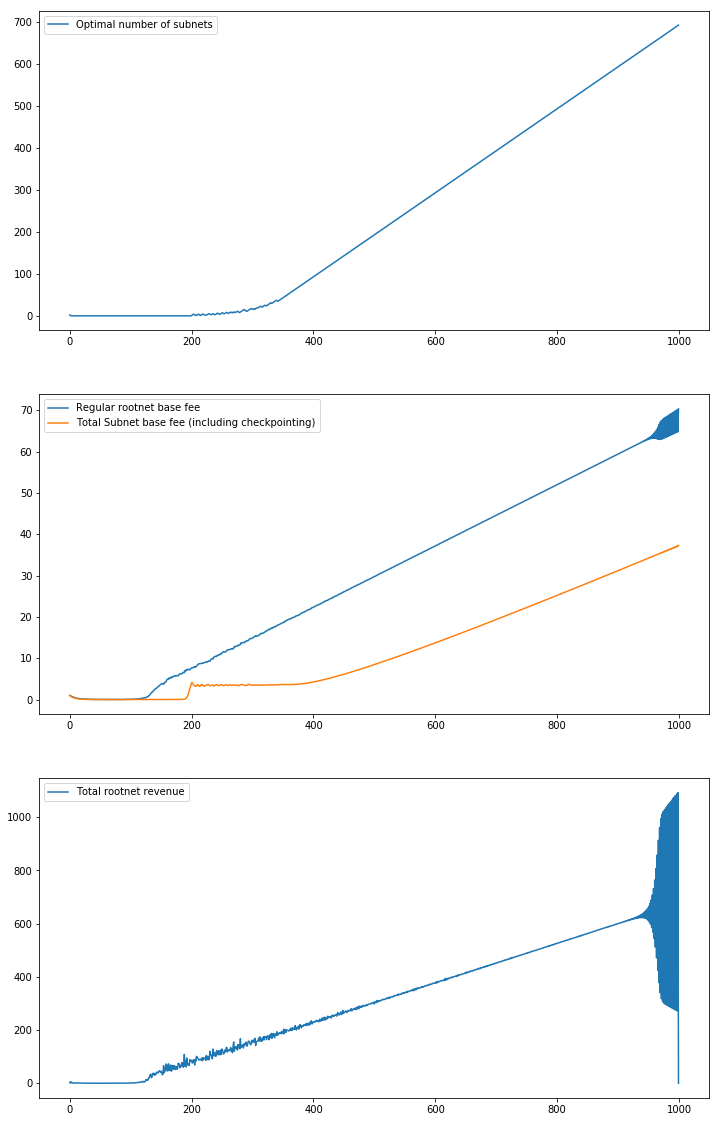

In [609]:
fig, axs = plt.subplots( 3,1,figsize=(12, 20))

axs[0].plot(x,NL,label='Optimal number of subnets')
axs[0].legend()


axs[1].plot(x,brL,label="Regular rootnet base fee")
axs[1].plot(x,g*bcL+bNL,label="Total Subnet base fee (including checkpointing)")
axs[1].legend()

axs[2].plot(x,brL*BBr+g*bcL*BBN,label="Total rootnet revenue")
axs[2].legend()


#Print total network revenue for whole period
print("Total rootnet token burn is", np.sum(brL*BBr+g*bcL*BBN))

## Number of subnets target

Here we try out the Sigmoidal updating rule, but using different targets, for instance first we attempt to maximize the number of subnets.

In [610]:
def fa(N1,N2,Br1,Br2,BN1,BN2,g,d):
    targch=N1-N2
    G= g*(BN1-BN2)-(Br1-Br2)
    return 1-d*np.tanh(targch*G/BT)


In [611]:
#define output vectors

brL=np.zeros(L)
bcL=np.zeros(L)
bNL=np.zeros(L)
NL=np.zeros(L)
a=np.zeros(L)


BBr=np.zeros(L)
BBN=np.zeros(L)
BBc=np.zeros(L)
    
brL[0]=br0
bcL[0]=bc0
bNL[0]=bN0
NL[0]=N0
a[0]=a0
a[1]=a1

In [612]:
#run stuff!

#generate mempools

ffa=np.zeros(L)

#first two steps without updating $a$
for l in range (0,1):
    Mr[l]=memer(D[l],BT,brL[l],bcL[l],bNL[l],lamr,lams,g)
    Ms[l]=memes(D[l],BT,brL[l],bcL[l],bNL[l],lamr,lams,g)
    BBr[l]=Br(Mr[l],brL[l])
    BBN[l]=BN(Ms[l],bNL[l],g,bcL[l])
    BBc[l]=Bc(BBN[l],g)
    
    #update base fees
    brL[l+1]=EIPr(BBr[l],a[l],BT)*brL[l]
    bcL[l+1]=EIPc(BBc[l],a[l],BT)*bcL[l]
    bNL[l+1]=EIPN(BBN[l],BT,NL[l])*bNL[l]
    
    ### first go with constant 50-50 split (here would go fancy HC algorithm)
    a[l+1]=0.5

    
    ###
    if NL[l]==0:
        NL[l+1]=1
        
    elif NL[l]==1:
        b1=EIPN(BBN[l],BT,1)*bNL[l]
        b2=EIPN(BBN[l],BT,2)*bNL[l]
        B1=BN(Ms[l],b1,g,bcL[l])
        B2=BN(Ms[l],b2,g,bcL[l])
        NL[l+1]=1+np.argmax([b1*B1,b2*B2])
        
    elif NL[l]>1:
        b1=EIPN(BBN[l],BT,NL[l]-1)*bNL[l]
        b2=EIPN(BBN[l],BT,NL[l])*bNL[l]
        b3=EIPN(BBN[l],BT,NL[l]+1)*bNL[l]
        B1=BN(Ms[l],b1,g,bcL[l])
        B2=BN(Ms[l],b2,g,bcL[l])
        B3=BN(Ms[l],b3,g,bcL[l])
        NL[l+1]=int(NL[l]-1+np.argmax([b1*B1,b2*B2,b3*B3]))
    
    
    
    
    
##The rest of the steps
for l in range(1,L-1):
    Mr[l]=memer(D[l],BT,brL[l-1],bcL[l-1],bNL[l-1],lamr,lams,g)
    Ms[l]=memes(D[l],BT,brL[l-1],bcL[l-1],bNL[l-1],lamr,lams,g)
    BBr[l]=Br(Mr[l],brL[l])
    BBN[l]=BN(Ms[l],bNL[l],g,bcL[l])
    BBc[l]=Bc(BBN[l],g)
    
    #update base fees
    brL[l+1]=EIPr(BBr[l],a[l],BT)*brL[l]
    bcL[l+1]=EIPc(BBc[l],a[l],BT)*bcL[l]
    bNL[l+1]=EIPN(BBN[l],BT,NL[l])*bNL[l]
    
    
    ### first go with constant 50-50 split (here would go fancy HC algorithm)
    ffa[l]=fa(NL[l],NL[l-1],BBr[l],BBr[l-1],BBN[l],BBN[l-1],g,d)
    a[l+1]=fa(NL[l],NL[l-1],BBr[l],BBr[l-1],BBN[l],BBN[l-1],g,d)*a[l]
    if a[l+1]>1:
        a[l+1]=a[l]
    elif a[l+1]<0:
        a[l+1]=a[1]
   
  
    ###
    if NL[l]==0:
        NL[l+1]=1
        
    elif NL[l]==1:
        b1=EIPN(BBN[l],BT,1)*bNL[l]
        b2=EIPN(BBN[l],BT,2)*bNL[l]
        bc=EIPc(BBc[l],a[l],BT)*bcL[l]
        B1=BN(Ms[l],b1,g,bcL[l])
        B2=BN(Ms[l],b2,g,bcL[l])
        NL[l+1]=1+np.argmax([b1*B1-bc*g*B1,b2*B2-bc*g*B2])
        
    elif NL[l]>1:
        b1=EIPN(BBN[l],BT,NL[l]-1)*bNL[l]
        b2=EIPN(BBN[l],BT,NL[l])*bNL[l]
        b3=EIPN(BBN[l],BT,NL[l]+1)*bNL[l]
        bc=EIPc(BBc[l],a[l],BT)*bcL[l]
        B1=BN(Ms[l],b1,g,bcL[l])
        B2=BN(Ms[l],b2,g,bcL[l])
        B3=BN(Ms[l],b3,g,bcL[l])
        NL[l+1]=int(NL[l]-1+np.argmax([b1*B1-bc*g*B1,b2*B2-bc*g*B2,b3*B3-bc*g*B3]))
    

Total rootnet token burn is 5166694.981331823


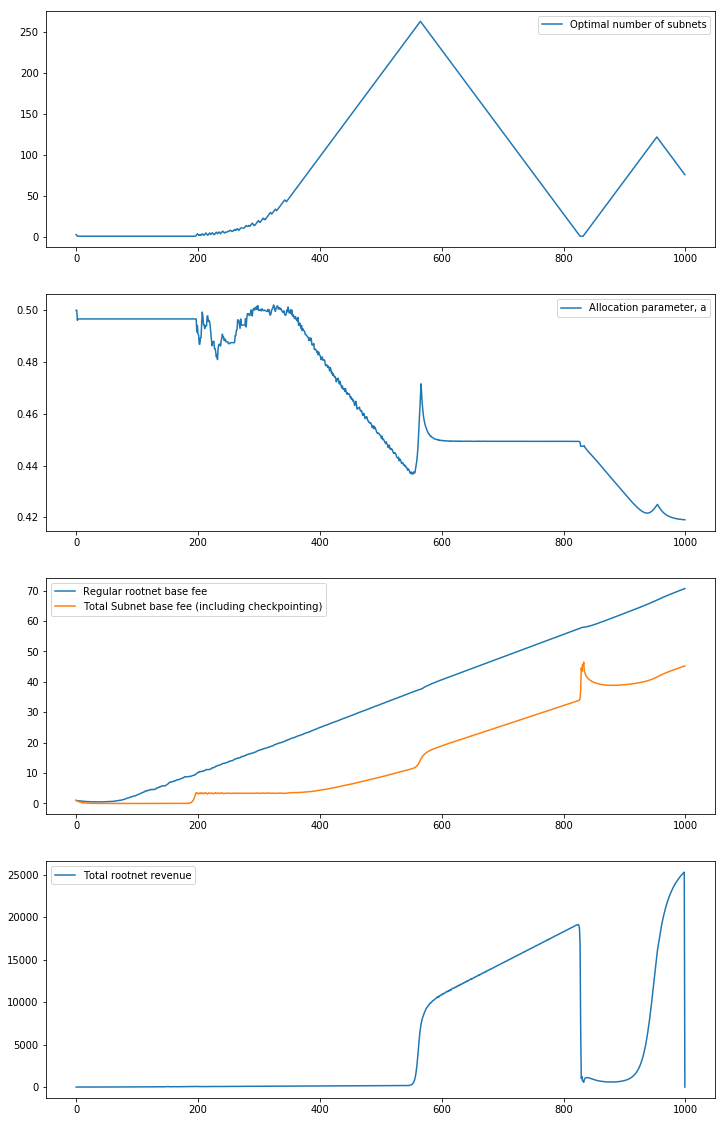

In [613]:
fig, axs = plt.subplots( 4,1,figsize=(12, 20))

axs[0].plot(x,NL,label='Optimal number of subnets')
axs[0].legend()

axs[1].plot(x,a,label="Allocation parameter, a")
axs[1].legend()

axs[2].plot(x,brL,label="Regular rootnet base fee")
axs[2].plot(x,g*bcL+bNL,label="Total Subnet base fee (including checkpointing)")
axs[2].legend()

axs[3].plot(x,brL*BBr+g*bcL*BBN,label="Total rootnet revenue")
axs[3].legend()


#Print total network revenue for whole period
print("Total rootnet token burn is", np.sum(brL*BBr+g*bcL*BBN))

## Lowest rootnet base fee

In this case choose a target for a sigmoidal updating rule, that is maximized by acheiving the lowest checkpointing base fee.

In [632]:
def fa(br1,br2,Br1,Br2,bc1,bc2,BN1,BN2,g,d):
    
    targch=1/(br1-br2)
    G= g*(BN1-BN2)-(Br1-Br2)
    return 1-d*np.tanh(targch*G/BT)


In [633]:
#define output vectors

brL=np.zeros(L)
bcL=np.zeros(L)
bNL=np.zeros(L)
NL=np.zeros(L)
a=np.zeros(L)


BBr=np.zeros(L)
BBN=np.zeros(L)
BBc=np.zeros(L)
    
brL[0]=br0
bcL[0]=bc0
bNL[0]=bN0
NL[0]=N0
a[0]=a0
a[1]=a1

In [634]:
#run stuff!

#generate mempools

ffa=np.zeros(L)

#first two steps without updating $a$
for l in range (0,1):
    Mr[l]=memer(D[l],BT,brL[l],bcL[l],bNL[l],lamr,lams,g)
    Ms[l]=memes(D[l],BT,brL[l],bcL[l],bNL[l],lamr,lams,g)
    BBr[l]=Br(Mr[l],brL[l])
    BBN[l]=BN(Ms[l],bNL[l],g,bcL[l])
    BBc[l]=Bc(BBN[l],g)
    
    #update base fees
    brL[l+1]=EIPr(BBr[l],a[l],BT)*brL[l]
    bcL[l+1]=EIPc(BBc[l],a[l],BT)*bcL[l]
    bNL[l+1]=EIPN(BBN[l],BT,NL[l])*bNL[l]
    
    ### first go with constant 50-50 split (here would go fancy HC algorithm)
    a[l+1]=0.5

    
    ###
    if NL[l]==0:
        NL[l+1]=1
        
    elif NL[l]==1:
        b1=EIPN(BBN[l],BT,1)*bNL[l]
        b2=EIPN(BBN[l],BT,2)*bNL[l]
        B1=BN(Ms[l],b1,g,bcL[l])
        B2=BN(Ms[l],b2,g,bcL[l])
        NL[l+1]=1+np.argmax([b1*B1,b2*B2])
        
    elif NL[l]>1:
        b1=EIPN(BBN[l],BT,NL[l]-1)*bNL[l]
        b2=EIPN(BBN[l],BT,NL[l])*bNL[l]
        b3=EIPN(BBN[l],BT,NL[l]+1)*bNL[l]
        B1=BN(Ms[l],b1,g,bcL[l])
        B2=BN(Ms[l],b2,g,bcL[l])
        B3=BN(Ms[l],b3,g,bcL[l])
        NL[l+1]=int(NL[l]-1+np.argmax([b1*B1,b2*B2,b3*B3]))
    
    
    
    
    
##The rest of the steps
for l in range(1,L-1):
    Mr[l]=memer(D[l],BT,brL[l-1],bcL[l-1],bNL[l-1],lamr,lams,g)
    Ms[l]=memes(D[l],BT,brL[l-1],bcL[l-1],bNL[l-1],lamr,lams,g)
    BBr[l]=Br(Mr[l],brL[l])
    BBN[l]=BN(Ms[l],bNL[l],g,bcL[l])
    BBc[l]=Bc(BBN[l],g)
    
    #update base fees
    brL[l+1]=EIPr(BBr[l],a[l],BT)*brL[l]
    bcL[l+1]=EIPc(BBc[l],a[l],BT)*bcL[l]
    bNL[l+1]=EIPN(BBN[l],BT,NL[l])*bNL[l]
    
    
    ### first go with constant 50-50 split (here would go fancy HC algorithm)
    ffa[l]=fa(brL[l],brL[l-1],BBr[l],BBr[l-1],bcL[l],bcL[l-1],BBN[l],BBN[l-1],g,d)
    a[l+1]=fa(brL[l],brL[l-1],BBr[l],BBr[l-1],bcL[l],bcL[l-1],BBN[l],BBN[l-1],g,d)*a[l]
    if a[l+1]>1:
        a[l+1]=a[l]
    elif a[l+1]<0:
        a[l+1]=a[1]
   
  
    ###
    if NL[l]==0:
        NL[l+1]=1
        
    elif NL[l]==1:
        b1=EIPN(BBN[l],BT,1)*bNL[l]
        b2=EIPN(BBN[l],BT,2)*bNL[l]
        bc=EIPc(BBc[l],a[l],BT)*bcL[l]
        B1=BN(Ms[l],b1,g,bcL[l])
        B2=BN(Ms[l],b2,g,bcL[l])
        NL[l+1]=1+np.argmax([b1*B1-bc*g*B1,b2*B2-bc*g*B2])
        
    elif NL[l]>1:
        b1=EIPN(BBN[l],BT,NL[l]-1)*bNL[l]
        b2=EIPN(BBN[l],BT,NL[l])*bNL[l]
        b3=EIPN(BBN[l],BT,NL[l]+1)*bNL[l]
        bc=EIPc(BBc[l],a[l],BT)*bcL[l]
        B1=BN(Ms[l],b1,g,bcL[l])
        B2=BN(Ms[l],b2,g,bcL[l])
        B3=BN(Ms[l],b3,g,bcL[l])
        NL[l+1]=int(NL[l]-1+np.argmax([b1*B1-bc*g*B1,b2*B2-bc*g*B2,b3*B3-bc*g*B3]))
    
  
    

Total rootnet token burn is 10066704.615567537


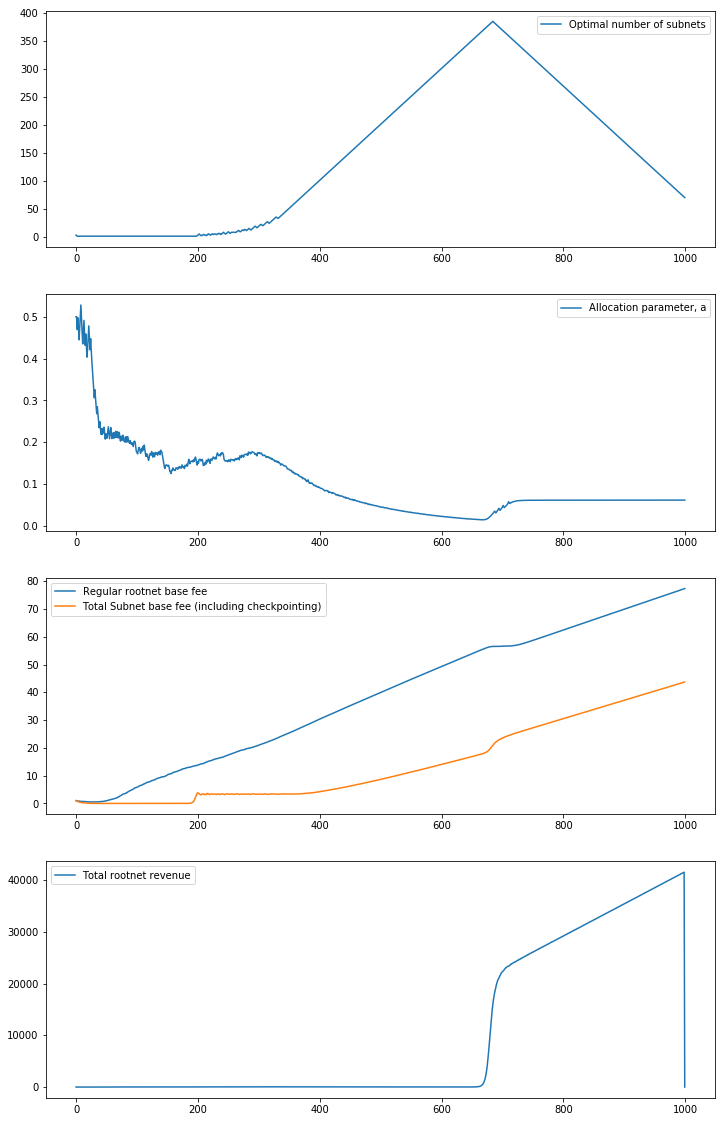

In [635]:
fig, axs = plt.subplots( 4,1,figsize=(12, 20))

axs[0].plot(x,NL,label='Optimal number of subnets')
axs[0].legend()

axs[1].plot(x,a,label="Allocation parameter, a")
axs[1].legend()

axs[2].plot(x,brL,label="Regular rootnet base fee")
axs[2].plot(x,g*bcL+bNL,label="Total Subnet base fee (including checkpointing)")
axs[2].legend()

axs[3].plot(x,brL*BBr+g*bcL*BBN,label="Total rootnet revenue")
axs[3].legend()

#Print total network revenue for whole period
print("Total rootnet token burn is", np.sum(brL*BBr+g*bcL*BBN))